In [2]:
import numpy as np
import pandas as pd 
import random
import os
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import re

import tensorflow as tf
import tensorflow.keras as keras
import keras.applications.xception as xception
from keras.layers import Input, Conv2D, Dense, Dropout, Flatten, Activation, \
MaxPooling2D, Input, GlobalAveragePooling2D, Lambda
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [3]:
# !pip install seaborn

### Storing the Waste Images

In [58]:
# Identifying the different waste classes
categories_dict = {0: "paper", 1: "cardboard", 2: "plastic", 3: "metal", 4: "battery", 5: "biological", 6: "trash", 
                  7: "clothes", 8: "shoes", 9: "white-glass", 10: "green-glass"}

# Path - location of data 
base_path ="garbage_classification/garbage_classification/"

# Matching the image size for the xception model
# Side note - The training accuracy didn't increase with an increased image size
IMAGE_WIDTH = 220    
IMAGE_HEIGHT = 220
IMAGE_CHANNELS = 3
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)

In [59]:
# Lists to store the filenames and categories
categories, filenames = [], []

# Loop through and store the filenames and categories
for category in categories_dict: 
    dir_filenames = os.listdir(base_path + categories_dict[category])
    filenames = filenames + dir_filenames
    categories = categories + [category] * len(dir_filenames)

# Create a DataFrame with the filename and corresponding category  
file_category_df = pd.DataFrame({'filename': filenames, 'category': categories})
file_category_df.head()

,filename,category
0,paper903.jpg,0
1,paper917.jpg,0
2,paper724.jpg,0
3,paper730.jpg,0
4,paper718.jpg,0


In [60]:
# Convert the file names for the organic images as they were previously downloaded/labelled with 'O_' instead of 
# 'organic' as the prefix 
# Now that the code has been executed multiple times, this cell is no longer as useful
file_category_df.loc[file_category_df["filename"].str.contains("O_"), 'filename'] = \
file_category_df.loc[file_category_df["filename"].str.contains("O_"), 'filename'].str.replace("O_", "organic")

file_category_df.loc[file_category_df["filename"].str.contains("organic")]

,filename,category


In [61]:
## Loop through and convert the filenames in the stored system folder too
##  Now that the code has been executed multiple times, this cell is no longer as useful

# dir_filenames = os.listdir(base_path + categories_dict[5])
# convert = lambda x: x[0 : re.search("\d", x).start()].replace("O_", "organic") + x[re.search("\d", x).start():]
# for file in dir_filenames: 
#     os.rename(base_path + "organic/" + file, base_path + "organic/" + convert(file))
#     print(base_path + "organic/" + convert(file))

In [62]:
# # Method name: add_class_name_prefix 
# # Parameters: 
#     # input_df - DataFrame containing the filenames and corresponding category
# # Output: DataFrame with converted values in the 'filenames' column
# # Add class name prefix to filename. So for example "/paper104.jpg" become "paper/paper104.jpg"
# def add_prefix_to_filename(input_df):
#     input_df['filename'] = input_df['filename'].apply(lambda x: x[0:re.search("\d", x).start()] + '/' + x)
#     return input_df
# file_category_df = add_prefix_to_filename(file_category_df)

# Convert the filenames to add a prefix 
file_category_converted_col = file_category_df['filename'].apply(lambda x : x[0:re.search("\d", x).start()] + f'/{x}')
file_category_df['filename'] = file_category_converted_col

# Shuffle the dataframe
file_category_df = file_category_df.sample(frac=1).reset_index(drop=True)
print(file_category_df.info())
file_category_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14908 entries, 0 to 14907
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  14908 non-null  object
 1   category  14908 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 233.1+ KB
None


,filename,category
0,trash/trash539.jpg,6
1,clothes/clothes3010.jpg,7
2,clothes/clothes848.jpg,7
3,plastic/plastic146.jpg,2
4,battery/battery322.jpg,4


<Figure size 1080x504 with 0 Axes>

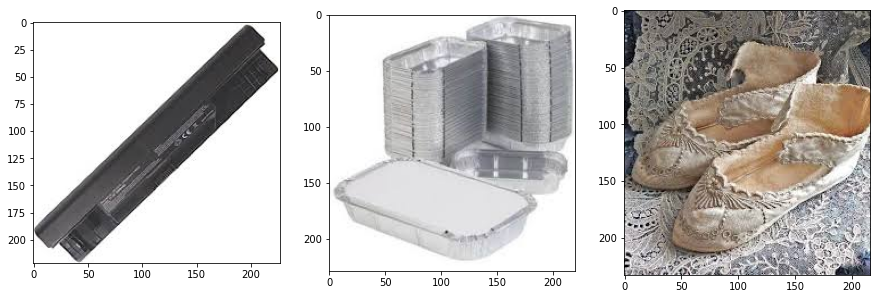

In [63]:
# Generate multiple images from the DataFrame
plt.figure()
plt.rcParams["figure.figsize"] = [15.00, 7.00]
f, axarr = plt.subplots(1,3) 
for i in range(3):
    sample_image = file_category_df.iloc[random.randint(0, len(file_category_df) - 1)]
    selected_random_image = tf.keras.utils.load_img(base_path + sample_image['filename'])
    axarr[i].imshow(selected_random_image)

### Vizualizations

Text(0.5, 1.0, '# Images Per Class')

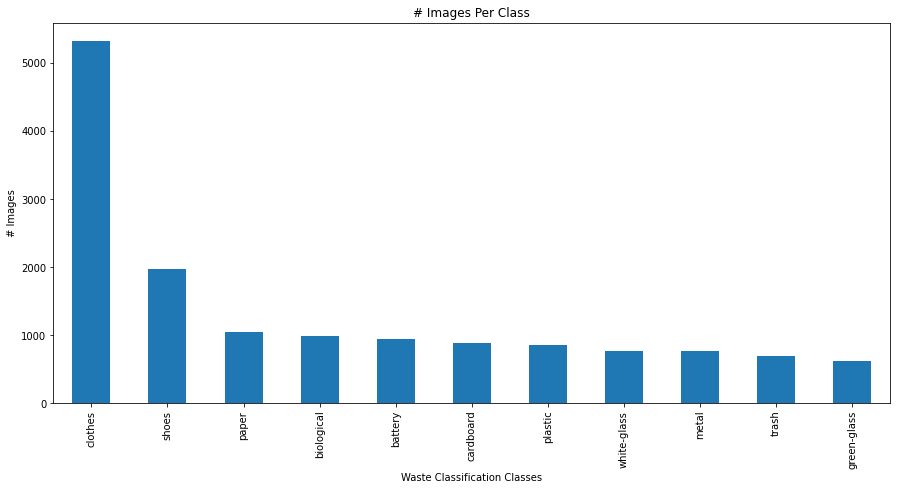

In [64]:
# Plot the number of images per class 
df_copy = file_category_df.copy()
df_copy['category'] = df_copy['category'].apply(lambda x : categories_dict[x])
df_copy['category'].value_counts().plot.bar()
plt.xlabel("Waste Classification Classes")
plt.ylabel("# Images")
plt.title("# Images Per Class")

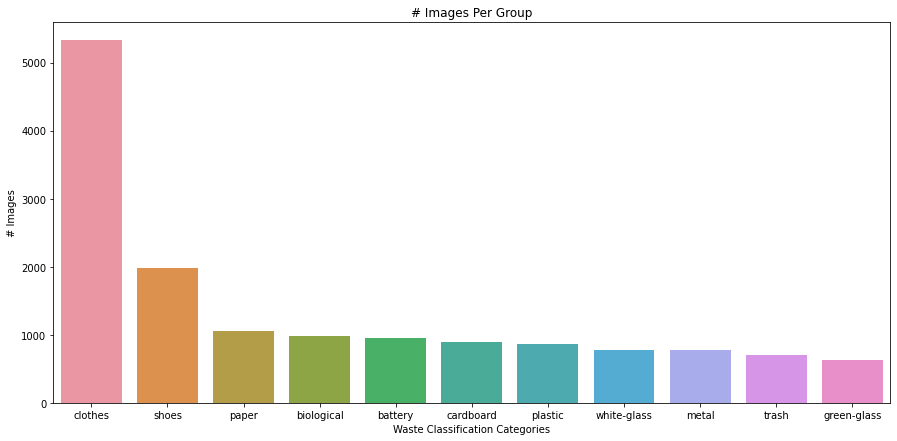

In [103]:
df_copy = file_category_df.copy()
df_copy['category'] = df_copy['category'].apply(lambda x : categories_dict[x])
category_value_counts = df_copy['category'].value_counts()
category_value_counts = pd.DataFrame(category_value_counts)
category_value_counts.reset_index(inplace=True)
sns.barplot(x = 'category',y = 'count', data = category_value_counts)
plt.xlabel("Waste Classification Categories")
plt.ylabel("# Images")
plt.title("# Images Per Group")
plt.show()

In [97]:
# Plot the number of images per waste group (compost, recycling, trash)
# compost - organic 
# recycling - paper, plastic, metal, cardboard 
# waste - trash, glass (glass is kind of tricky, so to be safe, I am placing it in the waste category)
waste_recyc_com_categories = {0: "waste", 1: "recycling", 2: "compost"}
waste = ["clothes", "trash", "white-glass", "green-glass", "shoes", "battery"]
recycling = ["paper", "plastic", "metal", "cardboard"]
compost = ["biological"]

In [98]:
# Method name: addWasteGroup 
# Parameters: 
    # row - DataFrame row containing the filenames and corresponding category for each image
# Output: Integer representing the key value of the corresponding waste group from the dictionary defined 
#         above named waste_recyc_com_categories
# Add the appropriate overarching waste group label to each image based on the lists defined in the previous cell 
def addWasteGroup(row): 
    row_filename = row['filename']
    prefix_end_index = re.search(r"\/", row_filename).start()
    filename_prefix = row_filename[:prefix_end_index]
    if filename_prefix in waste: 
        return 0
    elif filename_prefix in recycling: 
        return 1
    else: 
        return 2

In [99]:
file_category_df['waste_group'] = file_category_df.apply(lambda row: addWasteGroup(row), axis=1)
file_category_df.head(10)

,filename,category,waste_group
0,trash/trash539.jpg,6,0
1,clothes/clothes3010.jpg,7,0
2,clothes/clothes848.jpg,7,0
3,plastic/plastic146.jpg,2,1
4,battery/battery322.jpg,4,0
5,clothes/clothes2195.jpg,7,0
6,clothes/clothes1804.jpg,7,0
7,white-glass/white-glass633.jpg,9,0
8,clothes/clothes3345.jpg,7,0
9,shoes/shoes513.jpg,8,0


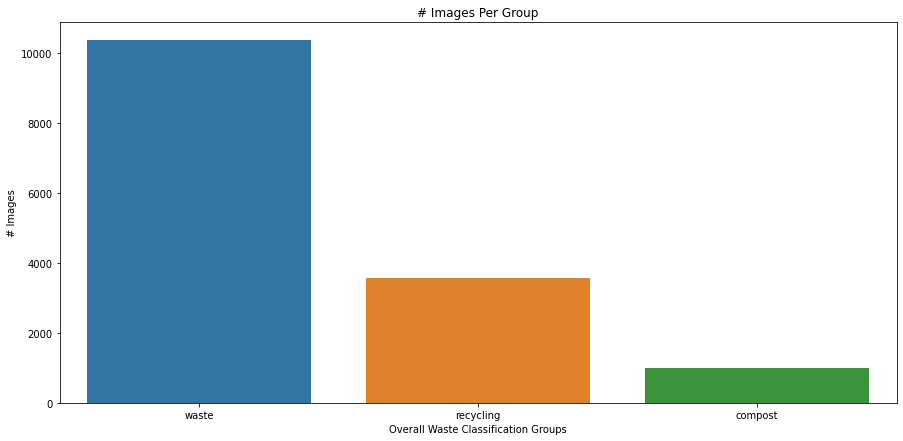

In [102]:
# Plot the number of images per waste group 
df_copy = file_category_df.copy()
df_copy['waste_group'] = df_copy['waste_group'].apply(lambda x : waste_recyc_com_categories[x])
waste_group_value_counts = df_copy['waste_group'].value_counts()
waste_group_value_counts = pd.DataFrame(waste_group_value_counts)
waste_group_value_counts.reset_index(inplace=True)
sns.barplot(x = 'waste_group', y = 'count', data = waste_group_value_counts)
plt.xlabel("Overall Waste Classification Groups")
plt.ylabel("# Images")
plt.title("# Images Per Group")
plt.show()

### Altering the Images 

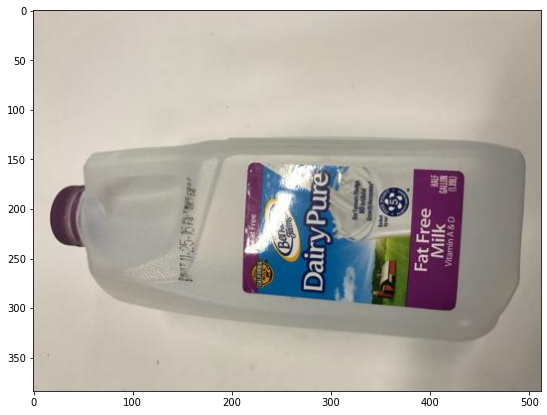

In [104]:
random_img_ex = file_category_df.loc[3, 'filename']
img_ex = tf.keras.utils.load_img(base_path + "/" + random_img_ex)
plt.imshow(img_ex)

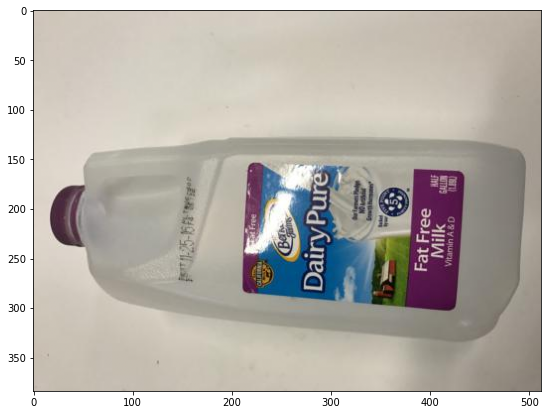

In [105]:
# Normalization
np_img = np.array(img_ex)
norm_image = (np_img - np.min(np_img)) / (np.max(np_img) - np.min(np_img))
plt.imshow(norm_image)

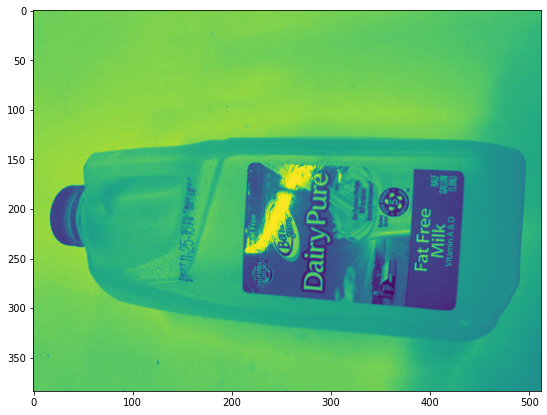

In [106]:
# Gray Scale
plt.imshow(tf.image.rgb_to_grayscale(
    np.array(img_ex), name=None
))

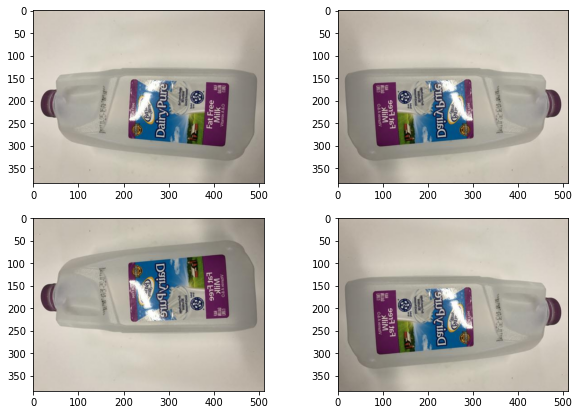

In [107]:
# Flipping the image relative to x and y axis 
plt.figure(figsize=(10, 7))
for i in range(4): 
    ax = plt.subplot(2, 2, i + 1)
    if i % 2 == 0:
        plt.imshow(tf.image.random_flip_up_down(np_img))
    else: 
        plt.imshow(tf.image.random_flip_left_right(np_img))

### Model 

In [19]:
# Defining the xception layer 
xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), \
                                   weights = 'imagenet')
# Not training the imported weights
for layer in xception_layer.layers:
    layer.trainable = False

# Compile the neural network 
model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

# Preprocessing
def xception_layer_preprocessing(img):
  return xception.preprocess_input(img)
# model.add(tf.keras.Sequential([
#             tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
#             tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# ]))
# model.add(tf.keras.Sequential([
#                             tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#                             tf.keras.layers.experimental.preprocessing.RandomRotation((-0.4, 0.4))
# ]))
model.add(Lambda(xception_layer_preprocessing))

model.add(xception_layer)
# model.add(Dropout(0.2))
# model.add(tf.keras.layers.Conv2D(32, 3, activation = 'softmax')),
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(categories_dict), activation='softmax')) 
# model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda (Lambda)             (None, 220, 220, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 11)                22539     
                                                                 
Total params: 20,884,019
Trainable params: 22,539
Non-trainable params: 20,861,480
_________________________________________________________________


In [20]:
early_stop = EarlyStopping(patience = 2, verbose = 1, monitor = 'val_categorical_accuracy', \
                           mode = 'max', min_delta = 0.001, restore_best_weights = True)

In [21]:
# Change the categories from numbers to names
file_category_df["category"] = file_category_df["category"].replace(categories_dict) 

# Split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(file_category_df, stratify=file_category_df['category'], test_size=0.2)
validate_df, test_df = train_test_split(validate_df, stratify=validate_df['category'],test_size=0.5)

In [22]:
batch_size = 64
train_df = train_df.reset_index(drop=True)
train_datagen = image.ImageDataGenerator(
#     rescale=1./255.,
    horizontal_flip=True,
    vertical_flip = True,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 11926 validated image filenames belonging to 11 classes.


In [23]:
validation_datagen = image.ImageDataGenerator()
validate_df = validate_df.reset_index(drop=True)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 1491 validated image filenames belonging to 11 classes.


In [24]:
test_datagen = image.ImageDataGenerator()
test_df = test_df.reset_index(drop=True)
test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    batch_size=1,
    shuffle=False 
)

Found 1491 validated image filenames belonging to 11 classes.


In [52]:
# Fit model to the training data 
EPOCHS = 15
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validate_df)//batch_size,
    steps_per_epoch=len(train_df)//batch_size,
    callbacks=[early_stop]
)

Epoch 1/15
186/186 [==============================] - 1138s 6s/step - loss: 0.4939 - categorical_accuracy: 0.8652 - val_loss: 0.2301 - val_categorical_accuracy: 0.9436
Epoch 2/15
186/186 [==============================] - 1078s 6s/step - loss: 0.2043 - categorical_accuracy: 0.9443 - val_loss: 0.1899 - val_categorical_accuracy: 0.9463
Epoch 3/15
186/186 [==============================] - 889s 5s/step - loss: 0.1556 - categorical_accuracy: 0.9546 - val_loss: 0.1722 - val_categorical_accuracy: 0.9511
Epoch 4/15
186/186 [==============================] - 1193s 6s/step - loss: 0.1289 - categorical_accuracy: 0.9632 - val_loss: 0.1637 - val_categorical_accuracy: 0.9490
Epoch 5/15
186/186 [==============================] - 864s 5s/step - loss: 0.1093 - categorical_accuracy: 0.9702 - val_loss: 0.1599 - val_categorical_accuracy: 0.9545
Epoch 6/15
186/186 [==============================] - 917s 5s/step - loss: 0.0946 - categorical_accuracy: 0.9756 - val_loss: 0.1540 - val_categorical_accuracy: 0.

In [53]:
# Unfreeze the imported weights and fit the model again to the training data 
# Further fine-tuning
for layer in xception_layer.layers:
    layer.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 220, 220, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 11)                22539     
                                                                 
Total params: 20,884,019
Trainable params: 20,829,491
Non-trainable params: 54,528
_________________________________________________________________


In [54]:
model_data = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validate_df)//batch_size,
    steps_per_epoch=len(train_df)//batch_size,
    callbacks=[early_stop]
)

Epoch 1/15
186/186 [==============================] - 5373s 29s/step - loss: 0.3006 - categorical_accuracy: 0.9063 - val_loss: 0.8136 - val_categorical_accuracy: 0.8139
Epoch 2/15
186/186 [==============================] - 7221s 39s/step - loss: 0.1483 - categorical_accuracy: 0.9512 - val_loss: 0.4566 - val_categorical_accuracy: 0.9029
Epoch 3/15
186/186 [==============================] - 5558s 30s/step - loss: 0.1028 - categorical_accuracy: 0.9685 - val_loss: 0.2172 - val_categorical_accuracy: 0.9429
Epoch 4/15
186/186 [==============================] - 5393s 29s/step - loss: 0.0974 - categorical_accuracy: 0.9708 - val_loss: 0.3427 - val_categorical_accuracy: 0.9076
Epoch 5/15
186/186 [==============================] - 3929s 21s/step - loss: 0.0761 - categorical_accuracy: 0.9786 - val_loss: 0.5552 - val_categorical_accuracy: 0.8573
Epoch 5: early stopping


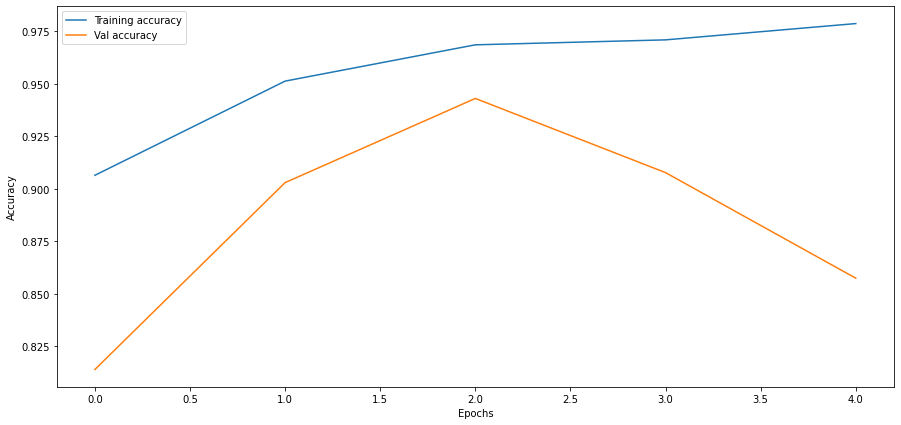

In [131]:
# Plotting accuracy 
plt.plot(model_data.history['categorical_accuracy'], label="Training accuracy")
plt.plot(model_data.history['val_categorical_accuracy'], label="Val accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

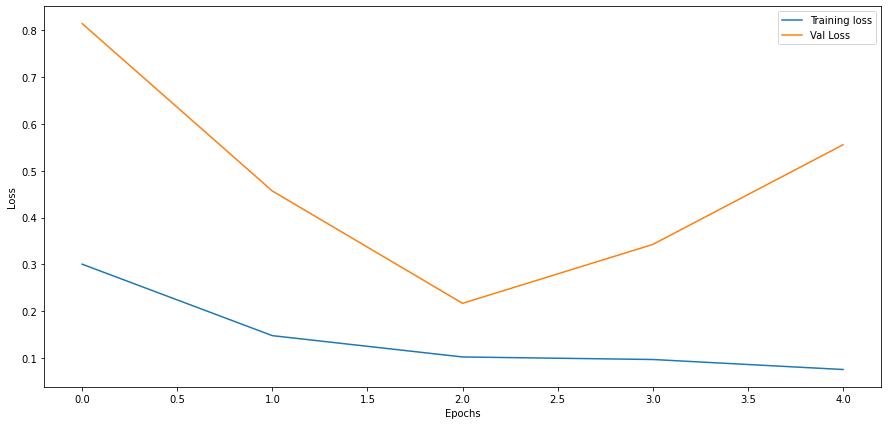

In [129]:
# Plotting loss
plt.plot(model_data.history['loss'], label="Training loss")
plt.plot(model_data.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [64]:
throwaway_variable, accuracy = model.evaluate(test_generator)

1491/1491 [==============================] - 132s 88ms/step - loss: 0.2022 - categorical_accuracy: 0.9423


In [65]:
# Model's predictions 
test_generator.reset()
preds = model.predict(test_generator, len(test_generator.filenames))

# Category with the highest predicted probability
preds = preds.argmax(1)

1491/1491 [==============================] - 130s 87ms/step


In [66]:
# Convert category number to corresponding category name
models_labels = {}
for item in test_generator.class_indices.items(): 
    models_labels[item[1]] = item[0]
cat_preds = [models_labels[pred] for pred in preds]
labels = test_df['category'].to_numpy()

In [67]:
print(classification_report(labels, cat_preds))

              precision    recall  f1-score   support

     battery       0.89      0.96      0.92        94
  biological       0.95      0.96      0.95        98
   cardboard       0.95      0.97      0.96        89
     clothes       0.99      0.98      0.99       533
 green-glass       0.97      0.92      0.94        63
       metal       0.85      0.86      0.85        77
       paper       0.93      0.89      0.91       105
     plastic       0.90      0.80      0.85        87
       shoes       0.94      0.95      0.94       198
       trash       0.94      0.94      0.94        70
 white-glass       0.81      0.94      0.87        77

    accuracy                           0.94      1491
   macro avg       0.92      0.92      0.92      1491
weighted avg       0.94      0.94      0.94      1491



In [97]:
# Converting the report into a DataFrame
output_dict = classification_report(labels, cat_preds, output_dict=True)
output_results_df = pd.DataFrame(output_dict).transpose()
output_results_df

,precision,recall,f1-score,support
battery,0.891089,0.957447,0.923077,94.000000
biological,0.949495,0.959184,0.954315,98.000000
cardboard,0.945055,0.966292,0.955556,89.000000
clothes,0.994286,0.979362,0.986767,533.000000
green-glass,0.966667,0.920635,0.943089,63.000000
metal,0.846154,0.857143,0.851613,77.000000
paper,0.930000,0.885714,0.907317,105.000000
plastic,0.897436,0.804598,0.848485,87.000000
shoes,0.940000,0.949495,0.944724,198.000000
trash,0.942857,0.942857,0.942857,70.000000


In [110]:
# Analyze the precision relative to the overarching waste categories of trash, recycling, and compost 
waste_stats = []
recycling_stats = []
compost_stats = []
for category in list(output_results_df.index): 
    if category in waste: 
        waste_stats.append(output_results_df.loc[category, 'precision'])
    elif category in recycling: 
        recycling_stats.append(output_results_df.loc[category, 'precision'])
    else: 
        compost_stats.append(output_results_df.loc[category, 'precision'])

In [117]:
waste_avg = np.array(waste_stats).mean()
print("Waste Avg: ", waste_avg)
recycling_avg = np.array(recycling_stats).mean()
print("Recycling Avg: ", recycling_avg)
compost_avg = np.array(compost_stats).mean()
print("Compost Avg: ", compost_avg)

Waste Avg:  0.9239812327942265
Recycling Avg:  0.9046611721611721
Compost Avg:  0.9386999047105344


In [132]:
# Next iteration: 
    # Try implementing Batch Normalization 
    # Further optimize the learning rate when unfreezing the imported weights 

### Waste Group Classification

In [26]:
# Defining the xception layer 
xception_layer = xception.Xception(include_top = False, input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS), \
                                   weights = 'imagenet')
# Not training the imported weights
for layer in xception_layer.layers:
    layer.trainable = False

# Compile the neural network 
model = Sequential()
model.add(keras.Input(shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))

# Preprocessing
def xception_layer_preprocessing(img):
  return xception.preprocess_input(img)
# model.add(tf.keras.Sequential([
#             tf.keras.layers.experimental.preprocessing.Resizing(IMAGE_WIDTH, IMAGE_HEIGHT),
#             tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
# ]))
# model.add(tf.keras.Sequential([
#                             tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#                             tf.keras.layers.experimental.preprocessing.RandomRotation((-0.4, 0.4))
# ]))
model.add(Lambda(xception_layer_preprocessing))

model.add(xception_layer)
model.add(Dropout(0.15))
# model.add(tf.keras.layers.Conv2D(32, 3, activation = 'softmax')),
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(len(waste_recyc_com_categories), activation='softmax')) 
# model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 220, 220, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 6,147
Non-trainable params: 20,861,480
______________________________________

In [27]:
# Change the categories from numbers to names
file_category_df["waste_group"] = file_category_df["waste_group"].replace(waste_recyc_com_categories) 

# Split the data into two sets and then split the validate_df to two sets
train_df, validate_df = train_test_split(file_category_df, stratify=file_category_df['waste_group'], test_size=0.2)
validate_df, test_df = train_test_split(validate_df, stratify=validate_df['waste_group'],test_size=0.5)

In [28]:
batch_size = 64
train_df = train_df.reset_index(drop=True)
train_datagen = image.ImageDataGenerator(
#     rescale=1./255.,
    horizontal_flip=True,
    vertical_flip = True,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    base_path, 
    x_col='filename',
    y_col='waste_group',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 11926 validated image filenames belonging to 3 classes.


In [29]:
validation_datagen = image.ImageDataGenerator()
validate_df = validate_df.reset_index(drop=True)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    base_path, 
    x_col='filename',
    y_col='waste_group',
    target_size=IMAGE_SIZE,
    batch_size=batch_size
)

Found 1491 validated image filenames belonging to 3 classes.


In [30]:
test_datagen = image.ImageDataGenerator()
test_df = test_df.reset_index(drop=True)
test_generator = test_datagen.flow_from_dataframe(
    dataframe= test_df,
    directory=base_path,
    x_col='filename',
    y_col='waste_group',
    target_size=IMAGE_SIZE,
    batch_size=1,
    shuffle=False 
)

Found 1491 validated image filenames belonging to 3 classes.


In [31]:
# Fit model to the training data 
EPOCHS = 15
history = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validate_df)//batch_size,
    steps_per_epoch=len(train_df)//batch_size,
    callbacks=[early_stop]
)

Epoch 1/15
186/186 [==============================] - 1672s 9s/step - loss: 0.2837 - categorical_accuracy: 0.8878 - val_loss: 0.1824 - val_categorical_accuracy: 0.9321
Epoch 2/15
186/186 [==============================] - 877s 5s/step - loss: 0.1665 - categorical_accuracy: 0.9380 - val_loss: 0.1621 - val_categorical_accuracy: 0.9321
Epoch 3/15
186/186 [==============================] - 886s 5s/step - loss: 0.1437 - categorical_accuracy: 0.9477 - val_loss: 0.1507 - val_categorical_accuracy: 0.9409
Epoch 4/15
186/186 [==============================] - 1886s 10s/step - loss: 0.1281 - categorical_accuracy: 0.9526 - val_loss: 0.1347 - val_categorical_accuracy: 0.9450
Epoch 5/15
186/186 [==============================] - 861s 5s/step - loss: 0.1198 - categorical_accuracy: 0.9558 - val_loss: 0.1294 - val_categorical_accuracy: 0.9504
Epoch 6/15
186/186 [==============================] - 860s 5s/step - loss: 0.1110 - categorical_accuracy: 0.9600 - val_loss: 0.1236 - val_categorical_accuracy: 0.

In [32]:
# Unfreeze the imported weights and fit the model again to the training data 
# Further fine-tuning
for layer in xception_layer.layers:
    layer.trainable = True

model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0007), metrics=['categorical_accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, 220, 220, 3)       0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout (Dropout)           (None, 7, 7, 2048)        0         
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 3)                 6147      
                                                                 
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
_____________________________________

In [54]:
model_data = model.fit(
    train_generator, 
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=len(validate_df)//batch_size,
    steps_per_epoch=len(train_df)//batch_size,
    callbacks=[early_stop]
)

Epoch 1/15
186/186 [==============================] - 5373s 29s/step - loss: 0.3006 - categorical_accuracy: 0.9063 - val_loss: 0.8136 - val_categorical_accuracy: 0.8139
Epoch 2/15
186/186 [==============================] - 7221s 39s/step - loss: 0.1483 - categorical_accuracy: 0.9512 - val_loss: 0.4566 - val_categorical_accuracy: 0.9029
Epoch 3/15
186/186 [==============================] - 5558s 30s/step - loss: 0.1028 - categorical_accuracy: 0.9685 - val_loss: 0.2172 - val_categorical_accuracy: 0.9429
Epoch 4/15
186/186 [==============================] - 5393s 29s/step - loss: 0.0974 - categorical_accuracy: 0.9708 - val_loss: 0.3427 - val_categorical_accuracy: 0.9076
Epoch 5/15
186/186 [==============================] - 3929s 21s/step - loss: 0.0761 - categorical_accuracy: 0.9786 - val_loss: 0.5552 - val_categorical_accuracy: 0.8573
Epoch 5: early stopping


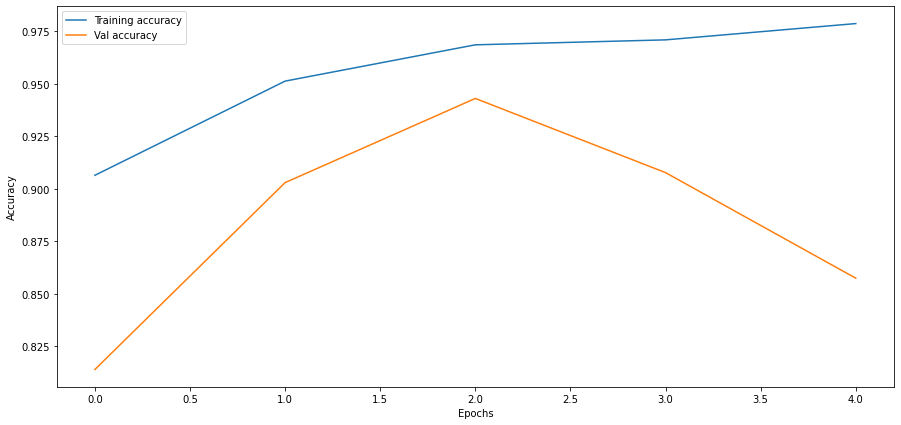

In [131]:
# Plotting accuracy 
plt.plot(model_data.history['categorical_accuracy'], label="Training accuracy")
plt.plot(model_data.history['val_categorical_accuracy'], label="Val accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

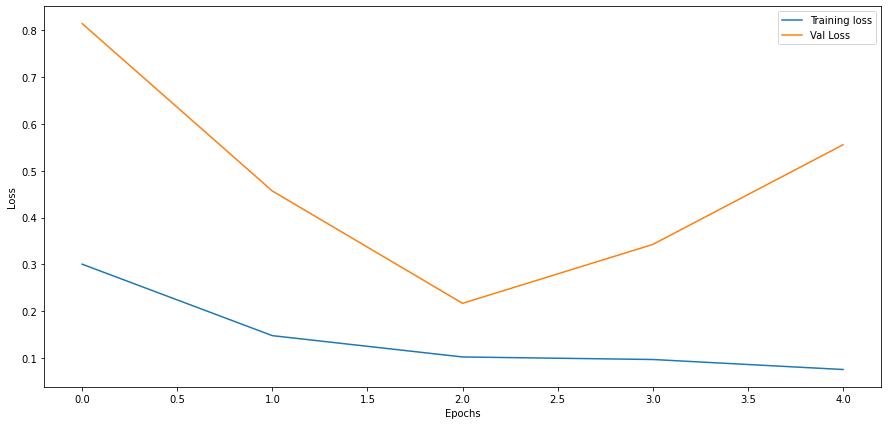

In [129]:
# Plotting loss
plt.plot(model_data.history['loss'], label="Training loss")
plt.plot(model_data.history['val_loss'], label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [33]:
throwaway_variable, accuracy = model.evaluate(test_generator)

1491/1491 [==============================] - 128s 85ms/step - loss: 0.1061 - categorical_accuracy: 0.9618


In [34]:
# Model's predictions 
test_generator.reset()
preds = model.predict(test_generator, len(test_generator.filenames))

# Category with the highest predicted probability
preds = preds.argmax(1)

1491/1491 [==============================] - 126s 84ms/step


In [47]:
# Convert category number to corresponding category name
models_labels = {}
for item in train_generator.class_indices.items(): 
    models_labels[item[1]] = item[0]
cat_preds = [models_labels[pred] for pred in preds]
labels = test_df['waste_group'].to_numpy()

In [53]:
print(classification_report(labels, cat_preds))

              precision    recall  f1-score   support

     compost       0.99      1.00      0.99        98
   recycling       0.91      0.94      0.92       358
       waste       0.98      0.97      0.97      1035

    accuracy                           0.96      1491
   macro avg       0.96      0.97      0.96      1491
weighted avg       0.96      0.96      0.96      1491



In [54]:
# Converting the report into a DataFrame
output_dict = classification_report(labels, cat_preds, output_dict=True)
output_results_df = pd.DataFrame(output_dict).transpose()
output_results_df

,precision,recall,f1-score,support
compost,0.989899,1.000000,0.994924,98.000000
recycling,0.910326,0.935754,0.922865,358.000000
waste,0.977539,0.967150,0.972317,1035.000000
accuracy,0.961771,0.961771,0.961771,0.961771
macro avg,0.959255,0.967635,0.963369,1491.000000
weighted avg,0.962213,0.961771,0.961929,1491.000000


In [52]:
print("Waste Avg: ", output_results_df.loc['waste'].precision)
print("Recycling Avg: ", output_results_df.loc['recycling'].precision)
print("Compost Avg: ", output_results_df.loc['compost'].precision)

Waste Avg:  0.9775390625
Recycling Avg:  0.9103260869565217
Compost Avg:  0.98989898989899


In [56]:
# Sorting by the overarching waste group category led to slightly more accurate and precise classification